In [3]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
device

device(type='cpu')

In [5]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\PC/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)
patch_size = dinov2_vits14.patch_size

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vitl14

In [7]:
transform1 = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

In [8]:
total_features  = []
root_path='C:/Users/PC/Downloads/DiNoV2_backup/'
folder_path=f'{root_path}/train/yes'
with torch.no_grad():
  list_img_path = os.listdir(folder_path)[0:4]
  for img_path in list_img_path:
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img).to(device)
    
    features_dict = dinov2_vits14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 384])

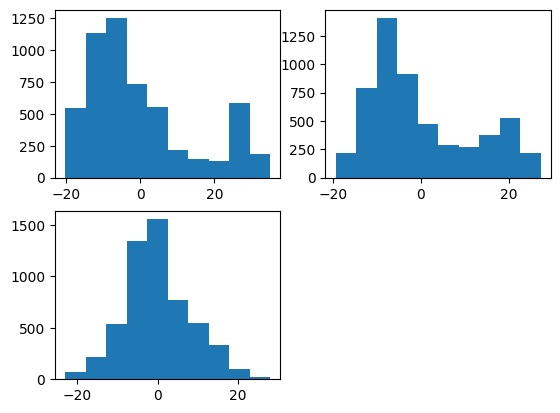

In [9]:
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

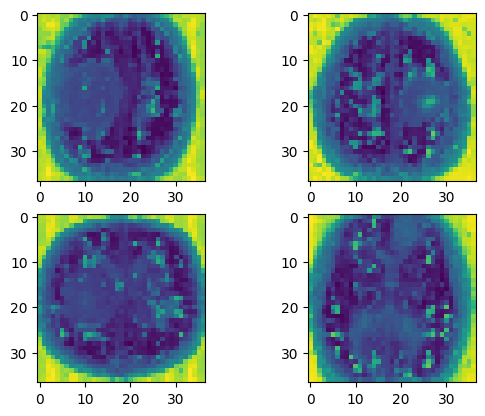

In [10]:
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

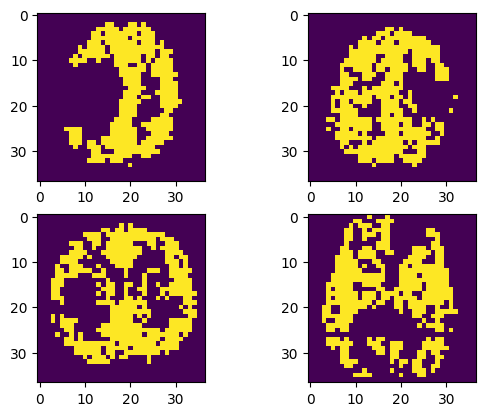

In [11]:
pca_features_bg = pca_features[:, 0] < 0.2 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

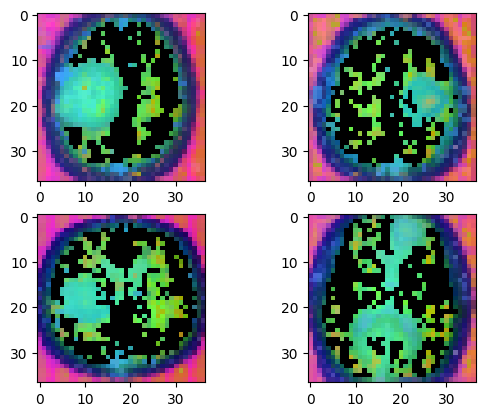

In [12]:
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(root_path, x), data_transforms[x]) 
    for x in ['train', 'test']
}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 186
     Root location: C:/Users/PC/Downloads/DiNoV2_backup/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 67
     Root location: C:/Users/PC/Downloads/DiNoV2_backup/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [15]:
batch_size = 8
num_workers = 4

data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=4)
    for x in ['train', 'test']
}

In [16]:
class_names = image_datasets['train'].classes
class_names

['no', 'yes']

In [17]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x
    
model = DinoVisionTransformerClassifier()
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [21]:
num_epoch = 10
over_loss=[]
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(data_loaders['train'])
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)
    over_loss.append(train_loss)  

Epoch [9/10]: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it, acc=0.25, loss=0.0581]


ValueError: x and y must have same first dimension, but have shapes (5,) and (120,)

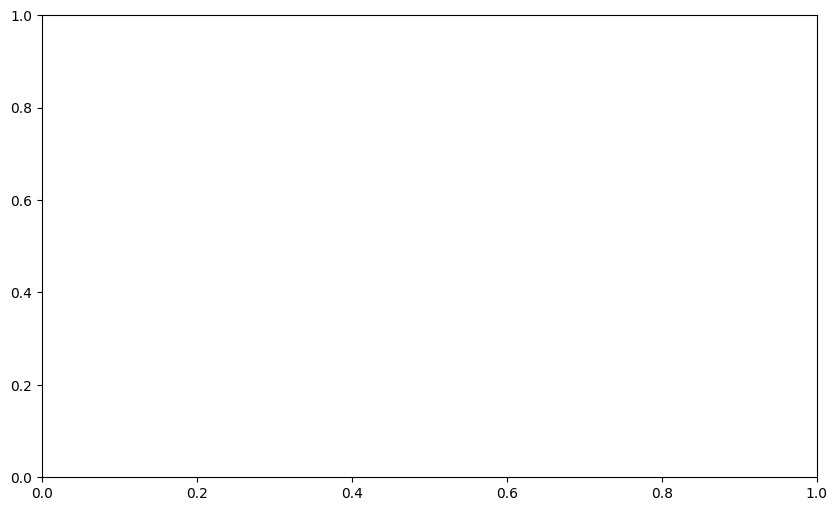

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epoch + 1), train_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels).sum().item()
        
        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(data_loaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 54 test images: 86 %


In [23]:
print(classification_report(test_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

          no       0.95      0.69      0.80        26
         yes       0.83      0.98      0.90        41

    accuracy                           0.87        67
   macro avg       0.89      0.83      0.85        67
weighted avg       0.88      0.87      0.86        67



In [24]:
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm, 
    index = class_names,
    columns = class_names
)
df_cm

,no,yes
no,18,8
yes,1,40


C:\Users\PC\AppData\Local\Temp\ipykernel_14712\101969818.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


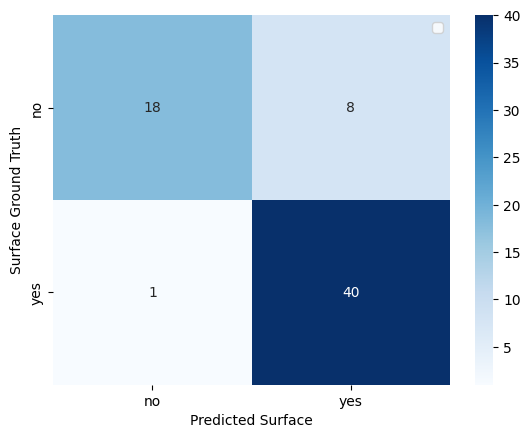

In [25]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)